# Setting up the calibration landscape (ecoregions, initial communities, climate etc.)

Now that we have initial parameters for our species, we need to define the landscape in which the calibration will take place.

To adapt to the Python functions I've made for these Jupyter Notebooks (see [here](./functionsForCalibration.py)), simulations will take place on a single cell. 

What we need is :

- The climate file
- The ecoregion file and PnET ecoregion parameters
- Initial communities files

## The climate file

See [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) for detailed information about what the climate file used in PnET simulations must contain.

[Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) recommends using a constant climate for calibrating (p. 69). Gustafson also recommends using an "ideal" climate at some points, but deciding what is an ideal climate for a given species is a difficult proposition. As we are going to compare the growth curves generated by PnET Succession with the growth curves generated by an empirical model like FVS (see [next section](./5.Obtaining_Growth_data_from_FVS.ipynb)), the idea will be rather to get long-term monthly averages (as recommanded by [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) p. 73) **in the region of the FVS variant that we are going to use** (or, if something else than FVS is used, long-term averages for the region where the empirical data comes from).

We have 5 variables that we need to gather :

- Maximum Monthly temperature (°C)
- Minimum Monthly temperature (°C)
- Photosynthetically Active Radiation (umol/m2/s)
- Sum of precipitations during the month (mm)
- Mean monthly atmospheric CO2 concentration (ppm)

### Climate data location for the calibration

Since we're doing calibration simulation here, we don't have a particular place where our simulation take place. It's up to us to choose where the climate data comes from, and there is not a "best" way to do things.

It's surely most likely better to use climate conditions that are closer to the average of the conditions we want to simulate in other LANDIS-II simulation rather than to extremes (especially for this first step of calibration). We also want to make sure that the location we use ca be inputted in FVSon.

I propose that we use an area near the border between the boral and temperate forest, and near the center of Ontario. It will be arbitrary.

Here is a map from of the forests of Ontario from the 2016 forest report of Ontario :

![](https://files.ontario.ca/1a-forestregion-map_e_1.png)

The city of [Chapleau](https://www.openstreetmap.org/#map=12/47.8416/-83.4106) seems to be located near the limit between the boreal and temperate forest. I created a simple shapefile polygon around the city that will serve to clip the climate data we want. See the next cell for a map.

In [29]:
# Displays a map where the shapefile that defines the boundaries of the climate data we wanna use is
import geopandas as gpd
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip

# Load the shapefile
# Replace 'path_to_shapefile.shp' with your actual shapefile path
gdf = gpd.read_file("./ReferencesAndData/ChapleauBoundariesClimate.shp")

# Check the CRS (Coordinate Reference System) of the shapefile
# If not in WGS84 (EPSG:4326), reproject it
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

# Create a map centered on the mean of the shapefile bounds
center_lat = gdf.unary_union.centroid.y
center_lon = gdf.unary_union.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add the GeoJSON data to the map with some styling
folium.GeoJson(
    gdf,
    name='Polygons',
    style_function=lambda x: {
        'fillColor': '#ebcb8b',
        'color': '#2e3440',
        'weight': 1,
        'fillOpacity': 0.4
    }
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Alternatively, you can use this simpler approach which works in newer versions of JupyterLab
display(m)

### Climate data source for 🌡️ temperature and 🌧️ precipitation

There are many sources of climate data. However, in this documentation, we will want to access both historical data and future data based on different scenarios for the different steps of the calibration. As such, we need :

- Data for all of Canada (since we want to do simulations throughout Canada in the DIVERSE project)
- Data that takes into account different Climate Models (e.g. ensemble data, percentiles, etc.) to take into account model variability
- Data that gives predictions of maximum and minimum temperatures, along with monthly sums of precipitations
- (Optional, but very useful) data that we can process easily through Python code to make things replicable.

I've looked at several data sources ([NclimGrid](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00332), [here](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily), [here](https://berkeleyearth.org/data/) etc.); but all were either just for the US, or just for historical data. We also have Worldclim and ClimateNA which are good, but of lesser quality from the one I choosed below.

In the end, the data from [climatedata.ca](https://climatedata.ca/) was the most adapted. I contacted them, and they sent me links to their [very detailed documentation](https://pavics.ouranos.ca/climate_analysis.html) allowing us to access their data with the OPeNDAP procotol, which avoids downloading the whole datasets - and make us able to access only the spatial/temporal chuncks we need.

The data we're using here comes from the future projection dataset [CanDSC-M6](https://climatedata.ca/resource/intro-to-candcs-m6/), which contains downscaled data from several Global Climate Models with a state-of-the-art methodology. See the following cell for data extraction.

However, **we are not going to use ensemble data** (percentiles accross several climate models) from CanDSC-M6, but rather data from a single climate model. This is because variables like temperature and precipitation have a great variability from month to month or year to year. Some years can see droughts, some years can see more rain. If we use ensemble data, we take into account inter-variability, but we completly loose the intra-model variability - which is crucial to model the more extreme conditions we see in real life when compared to the very "mild" and very average values obtained through percentiles.

We can see it clearly on this figure, which I generated with previous version of code from this notebook. The blue curve is precipitation data from a single climate model run; the orange curve is percentile data accross 17 different climate models. Both curve have approximately the same mean/average; but the variability is very different, and much higher in data from a single run.

![](./ReferencesAndData/Climate_Percentile_versus_SingleModel.png)

As such, we'll have to select one of the climate models whose data is available in CanDSC-M6. The idea is to select a model who's output are closest to the concensus/average/median among models, so that we still take into account inter-model variability by avoiding models that are at the extremes of this variability.

The following code cell does this by computing a standardized mean squared error for all 26 models of CanDCS-M6 and our three variables (precipitations, Tmin, Tmax) when compared to the median accross all models. It returns the models that is closest to the median overall, not just for one variable.

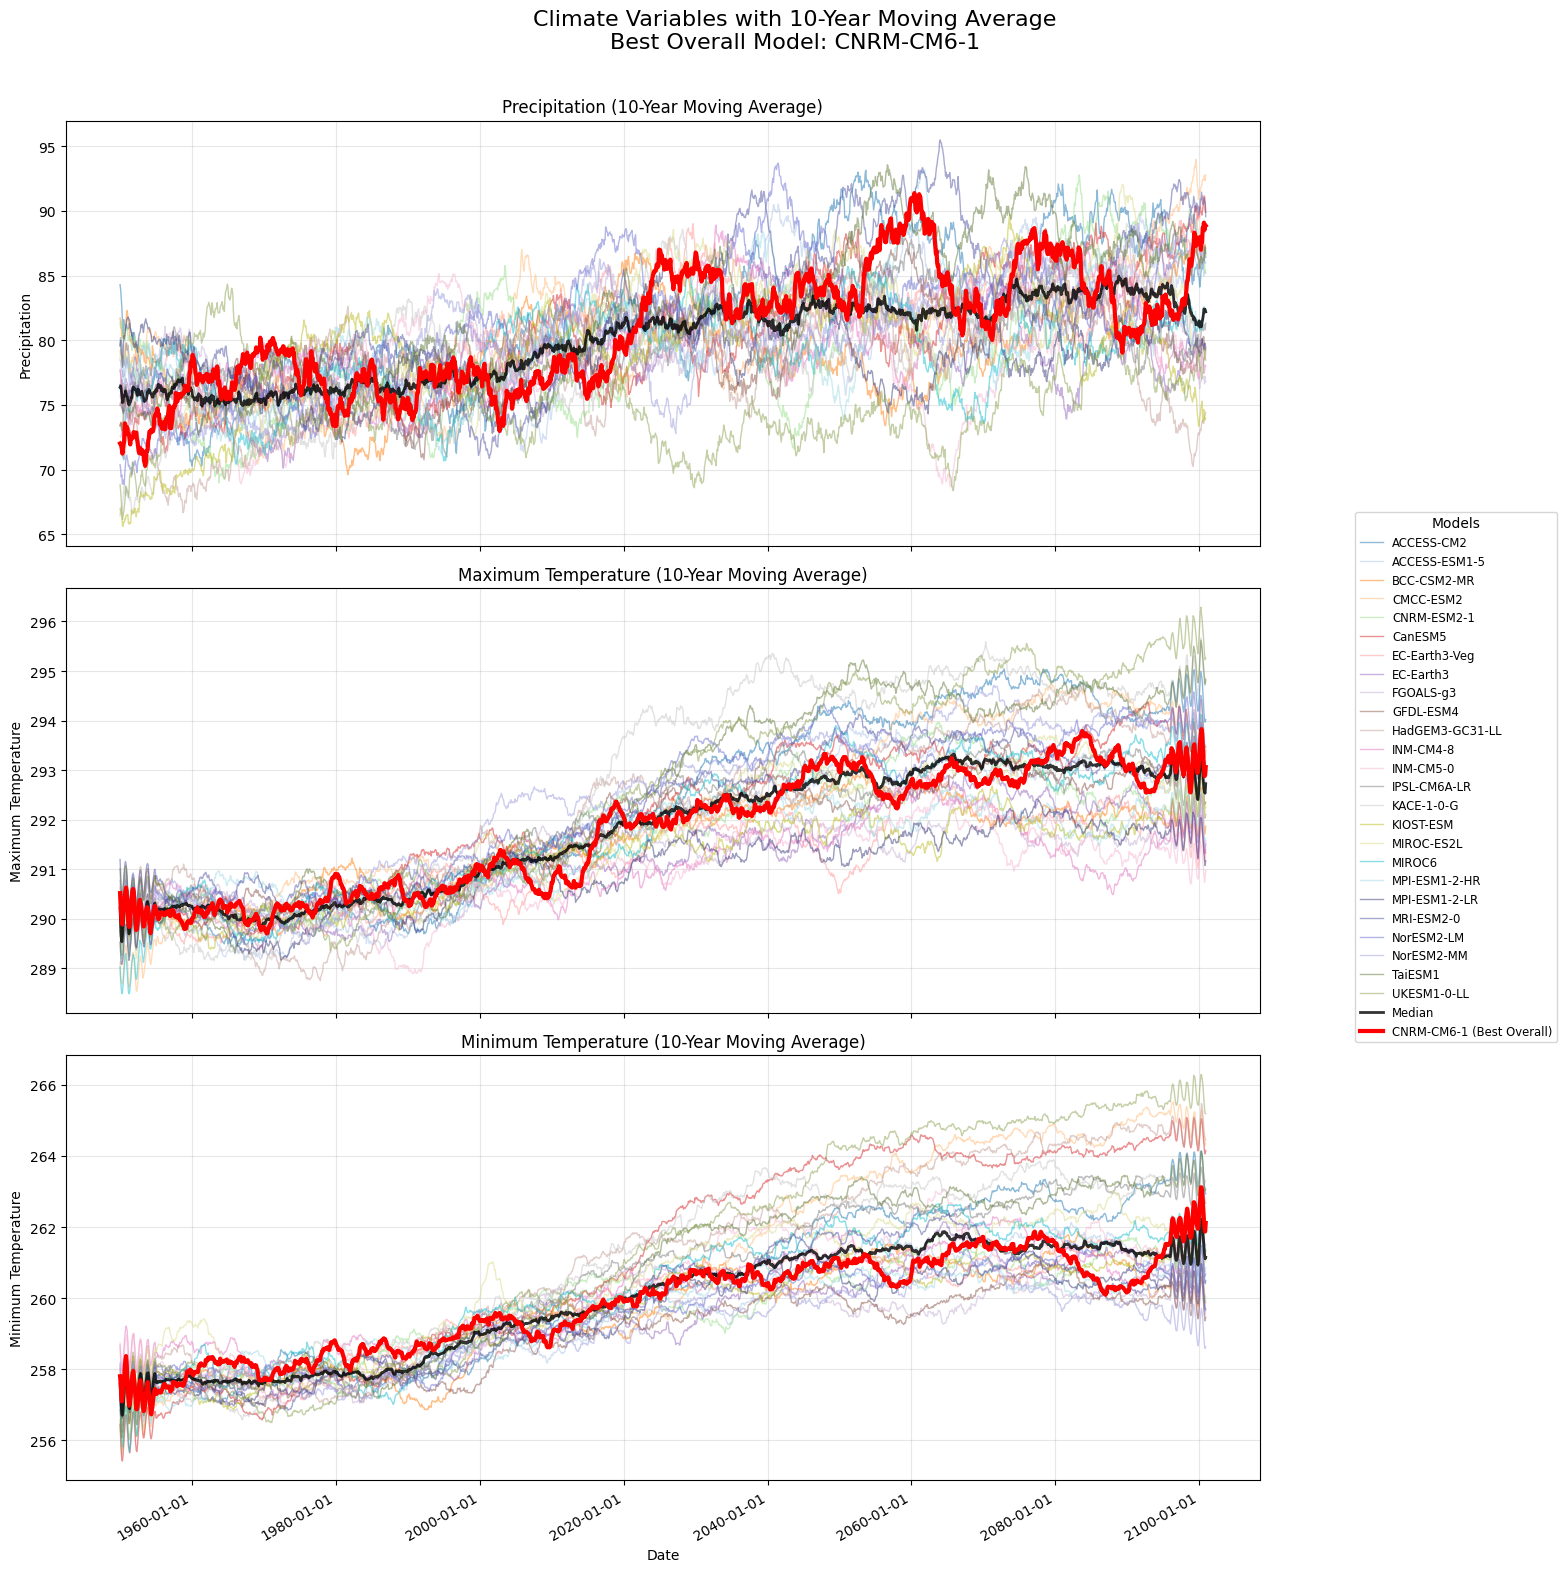

In [1]:
# This cell takes the precipitation, min and max temp data from CanDCS-M6
# and finds the model closts to the median accross all three variables using a standardized mean squarred approach

from functionsForCalibration import *
from siphon.catalog import TDSCatalog
import xarray as xr
from dask.diagnostics import ProgressBar
from IPython.display import display
from clisops.core import subset
import pandas as pd
import numpy as np
from tqdm import tqdm
    
# These URLs was made by browsing the THREDD server catalog of datasets, as was recommanded to me by email by the Canadian Centre for Climate Services (ECCC
# It points to the location of monthly total precipitation, Monthly tmax and tmin data for CanDCS-M6, and climate scenario SSP126.
# Here, we are in a folder with 26 different .nc files, corresponding to different GCMs runs
# We will loop to display each of them on a plot
# We can choose the ssp scenario; CanDCS-M6 has ssp126 (1-2.6), ssp245 (2-4.5), ssp370 (3-7.0), and ssp 585 (5-8.5).
sspScenario = "ssp126" # We use 126 for now as we'll do the calibration on historical, averaged data in the end anyway.
dictOfVariablesURL = {"prcptot":"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/prcptot/MS/" + sspScenario + "/simulations/catalog.xml",
                     "tn_min":"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/tn_min/MS/" + sspScenario + "/simulations/catalog.xml",
                     "tx_max":"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/tx_max/MS/" + sspScenario + "/simulations/catalog.xml"}

dictOfResults = {}

for variable in dictOfVariablesURL:
    # Create Catalog object
    cat = TDSCatalog(dictOfVariablesURL[variable])

    # Create dictionnary to fill with values
    variableMonthlyDict = dict()
    
    for datasetID in range(0, len(cat.datasets)):
        # Selects the dataset
        cds = cat.datasets[datasetID]
        # Gets the model name from the .nc file name
        modelName = str(cds).replace("_historical+" + sspScenario + "_1950-2100.nc", "").replace(variable + "_mon_MBCn+PCIC-Blend_", "")
        # Get the data for the Chapleau area
        ds = xr.open_dataset(cds.access_urls["OPENDAP"], chunks="auto")
        ds1 = subset.subset_shape(ds,
                                  shape="./ReferencesAndData/ChapleauBoundariesClimate.shp")
        ds_months = ds1[variable].isel(time=slice(0, 1812))
        # With this command, we can get the monthly averages across all cells in one very quick step
        # Instead of going from month to month with listOfPrecTotMonthly.append(float(testds.isel(time=month).mean().values))
        # Here, we use mean() to get the mean values accross all of the  cells in our polygon.
        # This works for precipitations too as mm are not dependent on the surface; 1mm of precipitation = 1l per m2. PnET takes
        # the same unit, so it's OK.
        listOVariableMonthly = ds_months.mean(dim=['lat', 'lon']).values.tolist()
        # We put the values in the dictionnary
        variableMonthlyDict[modelName] = listOVariableMonthly

    dictOfResults[variable] = variableMonthlyDict

# We create the list of years/months to plot
years = np.repeat(np.arange(1950, 2101), 12)
# Create months 1-12 for each year
months = np.tile(np.arange(1, 13), 2101-1950)
datesTime = [(str(year) + "-" + str(month).zfill(2) + "-01") for (month, year) in zip(months, years)]

fig, bestModel, modelScore = plot_climate_variables_with_moving_average(dictOfResults["prcptot"], dictOfResults["tx_max"], dictOfResults["tn_min"], datesTime, window_years=10)

This method allows us to select the model that fits in an automatized way, depending on the landscape we're working on. This will be useful for the main simulations we will do afterward for DIVERSE.

Different SSP scenarios give different fits, but it seems pretty robust to the size of the moving window we're using. But in the calibration, we'll use historical data. So, let's do it again for historical data :

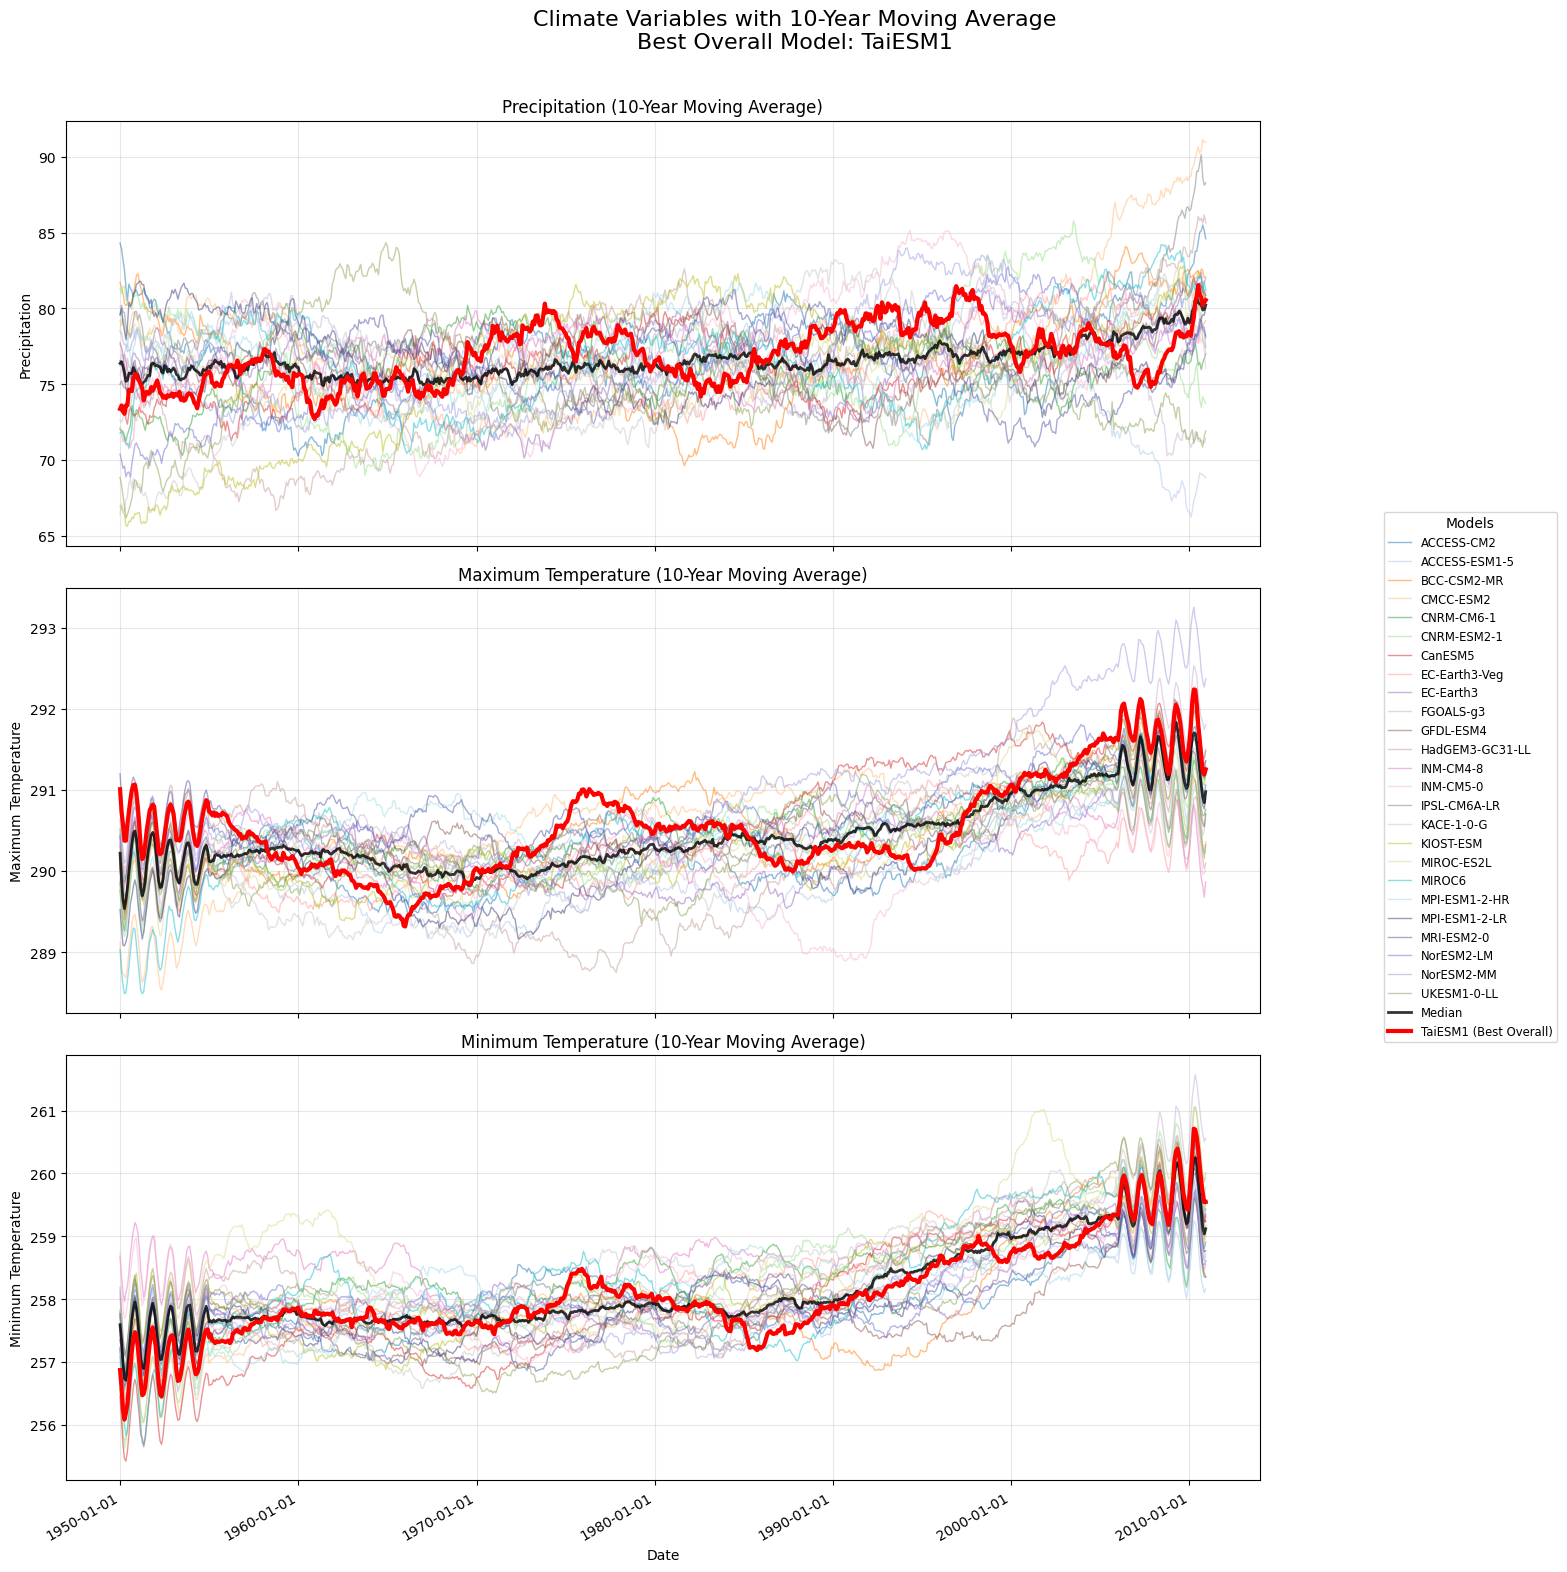

In [2]:
# We will now do the same as before, but use only data from 1950-2010, meaning the 732 first months of the sample.
import copy
dictOfResults_SampleHistorical = copy.deepcopy(dictOfResults)

for variable in dictOfResults_SampleHistorical:
    for model in dictOfResults_SampleHistorical[variable]:
        dictOfResults_SampleHistorical[variable][model] = dictOfResults_SampleHistorical[variable][model][0:732]

fig, bestModel, modelScore = plot_climate_variables_with_moving_average(dictOfResults_SampleHistorical["prcptot"],
                                                                        dictOfResults_SampleHistorical["tx_max"],
                                                                        dictOfResults_SampleHistorical["tn_min"],
                                                                        datesTime[0:732], window_years=10)

However, as recommanded by [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf), we will transform these climate conditions into constant conditions (accross the year, but variable between month) to avoid confounding the first step of the calibration with extreme events.

#### Extraction of 🌡 temperature and 🌧 precipitation data for Ontario, 1950-2100 from [CanDSC-M6](https://climatedata.ca/resource/intro-to-candcs-m6/)

The following cells are based on the documentation of Ouranos (the institution behind [climatedata.ca](https://climatedata.ca/) and [CanDSC-M6](https://climatedata.ca/resource/intro-to-candcs-m6/)) to access the data in Python.

They extract the climate variables (Tmax, Monthly Tmin, Sum of precipitations) at a monthly timestep for the different "cells" in the CanDSC-M6 (since the data is gridded on all of the earth), and then make a global value for the small landscape that we're simulating (average of Tmin, Tmax and precipitation sum for across all cells for the month).

In [24]:
# The code in this cell loads the functions needed to extract the climate data from the PAVIS database from Ouranos,
# using the CanDSC-M6 dataset
# We will use it to extract minimum and maximum monthly temp + total monthly precipitation for climate scenario SSP126
# The code in this cell will be re-used on other pages to generate the values for other climate scenarios
# Right now, it doesn't really matter since the first calibration step (monoculture in best conditions) will use
# historical data

# Importing the packages needed
# Siphon is used to connect to the data,
# xarray is used to manipulate the data objects
# The rest is for progress bars, utilities
# Clisops is used to subset the data based on a polygon
from functionsForCalibration import *
from siphon.catalog import TDSCatalog
import xarray as xr
from dask.diagnostics import ProgressBar
from IPython.display import display
from clisops.core import subset
import pandas as pd
import numpy as np
from tqdm import tqdm

# This function will help us define the URL to get the right dataset,
# corresponding to the right variable; the right SSP scenario; and the right model.
# This URL was made by browsing the THREDD server catalog of datasets, as was recommanded to me by email by the Canadian Centre for Climate Services (ECCC
# It points to the location of monthly maximum temperature data for CanDCS-M6, and climate scenario SSP126. The models are from CIMP6 from the IPCC.
def getURLDatasetCanDCSM6(variable, sspScenario, climateModel):
    
    url = ("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/"
           + str(variable)
           + "/MS/"
           + str(sspScenario)
           + "/simulations/"
           + str(variable)
           + "_mon_MBCn+PCIC-Blend_"
           + str(climateModel)
           + "_historical+ssp126_1950-2100.nc")
    return url

# Selector for the SSP scenario we want
# Here, we're looking for 1950-2010 historical data
# Therefore, it's not that much important. We will use SSP 1-2.6
sspScenario = "ssp126"

# We define the time period of the data we want and prepare the dataframe
# that we will export for PnET - that will ultimatily contain a monthly measure
# of Tmin, Tmax, Precpitations, CO2 and PAR for each months of each year
# Here, we want historical data; I limited to up to 2010 to get conditions
# not too influenced by climate changed. It's arbitrary.
startYear = 1950
endYear = 2010
years = np.repeat(np.arange(startYear, endYear+1), 12)
# Create months 1-12 for each year
months = np.tile(np.arange(1, 13), (endYear+1)-startYear)
# Create DataFrame
df = pd.DataFrame({
    'Year': years,
    'Month': months
})
numberOfMonths = len(df["Month"])

#################################################
# MAXIMUM MONTHLY TEMPERATURE
#################################################
# print(getURLDatasetCanDCSM6("tx_max",
                            # sspScenario,
                            # bestModel))

# This does not download the entire dataset, just the metadata and attributes describing the content.
ds = xr.open_dataset(getURLDatasetCanDCSM6("tx_max",
                                      sspScenario,
                                      bestModel),
                    chunks="auto")

# This prints information about the dataset
# display(ds)

# Subset the dataset by polygon
# What we get in ds1 is an array of grid cells with a third dimension corresponding to time
ds1 = subset.subset_shape(
    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp"
) 

# We select the variable data and months we need - all of them
# 0 is january of 1950. numberOfMonths is the number of months from 1950, defined
# at the beginning of the cell.
ds_months = ds1.tx_max.isel(time=slice(0, numberOfMonths))
# With this command, we can get the monthly averages across all cells in one very quick step
listOfTmaxMonthly = kelvin_to_celsius(ds_months.mean(dim=['lat', 'lon']).values.tolist())
df["Tmax"] = listOfTmaxMonthly

#################################################
# MINIMUM MONTHLY TEMPERATURE
#################################################
# We do the same as before, but for the minimum temperature recorded for the month
ds = xr.open_dataset(getURLDatasetCanDCSM6("tn_min",
                                          sspScenario,
                                          bestModel),
                     chunks="auto")
# Subset by polygon (small extent around the town of Chapleau, Ontario)
ds1 = subset.subset_shape(
    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp"
) 

# We select the variable data and months we need - all of them
ds_months = ds1.tn_min.isel(time=slice(0, numberOfMonths))
# With this command, we can get the monthly averages across all cells in one very quick step
listOfTminMonthly = kelvin_to_celsius(ds_months.mean(dim=['lat', 'lon']).values.tolist())
# print(ds1)
df["Tmin"] = listOfTminMonthly


#################################################
# PRECIPITATIONS
#################################################
# We do the same as before, but for the sum of precipitations for each month
ds = xr.open_dataset(getURLDatasetCanDCSM6("prcptot",
                                          sspScenario,
                                          bestModel),
                     chunks="auto")
# Subset by polygon (small extent around the town of Chapleau, Ontario)
ds1 = subset.subset_shape(
    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp"
) 
# We select the variable data and months we need - all of them
ds_months = ds1.prcptot.isel(time=slice(0, numberOfMonths))
# With this command, we can get the monthly averages across all cells in one very quick step
# Here, we use mean() to get the mean total precipitations for all of the  cells in our polygon.
# Precipitations in mm are not dependent on the surface; 1mm of precipitation = 1l per m2. PnET takes
# the same unit, so it's OK.
listOfPrecTotMonthly = ds_months.mean(dim=['lat', 'lon']).values.tolist()
df["SumOfPrecipitations"] = listOfPrecTotMonthly


#################################################
# EXPORT TO CSV
#################################################
# We output the dataframe to a .csv
df.to_csv("./ReferencesAndData/dataFrameClimate.csv", sep=',', index=False, encoding='utf-8')

print(df)

     Year  Month       Tmax       Tmin  SumOfPrecipitations
0    1950      1   1.766656 -40.488547            82.018227
1    1950      2   3.891656 -30.540625           121.325523
2    1950      3   7.339594 -32.717703            53.020832
3    1950      4  22.693750 -14.910406            68.468750
4    1950      5  28.860406  -6.858344            51.800781
..    ...    ...        ...        ...                  ...
727  2010      8  30.714594   5.745844            59.013020
728  2010      9  26.756250   0.412500            78.882812
729  2010     10  25.725000  -6.327094            81.093750
730  2010     11  12.475000 -14.025000            73.684898
731  2010     12   8.402094 -23.025000            77.760414

[732 rows x 5 columns]


### Climate data source for ☀ PAR (Photosynthetically Active Radiation)

Sadly, the CanDSC-M6 dataset used for Tmax, Tmin and Precipitations (see above) doesn't contain PAR data. In fact, after a bit of research, very few global datasets seem to have solar radiation variables, especially for several scenarios of climate change (RCP or SSP scenarios) like we will need in the end for this calibration but also for beyong. For example, ClimateNA or World Clim both do not have solar radiation data.

However, another dataset available from Climate Change Canada has PAR values, that they call Downwelling Shortwave Radiation : it is called [CanLEADv1](https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1/Cannon%20et%20al.%20-%202022%20-%20Canadian%20Large%20Ensembles%20Adjusted%20Dataset%20version%201%20%20CanLEADv1.pdf).

Problem is, CanLEADv1 doesn't have the same structure as CanDSC-M6 and doesn't cover many climat scenarios. It only has a "no forcing" scenario and a "RCp 8.5" scenario. Plus, it contains two sets 50 replicates based on two input/observed data, but without any ensemble percentile dataset available. Finally, it's not available through the OpENDAP protocol used above - meaning we have to download the entire datasets to work with it (around 30GB for the files concerning Tmax, Tmin, precipitations and PAR for just one replicate).

Talking with the Canadian Center for Climate Services by email, they recommanded that we use only data from CanLEADv1, and simply use an "indexing" method on Global Warming achieved through the simulation rather than time to get the climate values we want. The method is detailed [here](https://climate-scenarios.canada.ca/?page=CRBCPI-general-summary#5.4-development_of_warming_level-based_change_factors), [here](https://climate-scenarios.canada.ca/?page=buildings-report#2.3-communicating_uncertainty) and [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015GL063569). Basically, we would only use CanLEADv1 data (also for temperatures and precipitation); and the values we would take from the dataset for a moment T in LANDIS-II would be indexed on a 31-years average value centered on a year where the °C of Global Warming is reached in the climate scenario we are simulating. I'm not entirely sure about this approach; I feel like we would loose a lot of the advantages of the CanDSC-M6 data by using CanLEADv1.

Instead, I set out to use CanLEADv1 data to make a Generalized Additive Model (GAM) to predict PAR (which is in CanLEADv1) from monthly minimum temperature, maximum temperature and total precipitation (three variables we can both obtain for CanDSC-M6 and CanLEADv1). After a bit of experimentation, the GAM that I was able to produce seemed to have a good predictive power. Monthly averaged daily PAR is a very cyclic variable, with only small variations in its peak values for winter and summer.

In particular, I've looked at the difference between the monthly PAR values we are getting with this approach, versus those that were in files sent to us by Brian Sturtevant's team. They look very similar, although the amplitude of the variation of PAR throughout the year is higher in our case. This is very easy to understand : since the climate data I'm working with is higher in the north, then the values for summer and winter have more amplitude than in Minnesota where Brian's team work (because the days in winter and summer are shorter and longer in the north, respectively). So, everything seems fine !

Below is the code to download CanLEADv1 data, clip the data for the area of interested, format it, create a GAM, diagnose it, and then produce predicted values of PAR based on the CanDCS-M6 data we took above for the area.

In [25]:
# First step : We're going to download the data from CanLEADv1 (which contain PAR values),
# and select only what is of interest to us (monthly values inside the polygon of the area
# we are simulating), then format the data into a dataframe we will use to create a GAM (Generalize Additive Model) afterwards.
# WARNING : The climate files from CanLEADv1 are temporarely downloaded one by one in the calibration folder, but are deleted when the operation
# is done, as they are very heavy (betwee 6-8 GB per file, and there are 4 files in total).
# The files are at https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1/CanRCM4-EWEMBI-MBCn/r1_r1i1p1/, which
# corresponds to one of the 50 replicates of CanLEADv1 calibrated with the EWEMBI observational dataset.
# See https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1 for readmes and documentation.
# WARNING : If a download fails, you can relaunch the cell. Downloads are done with Axel, which can re-start a download from where it was.
from functionsForCalibration import *
shapefile_Chapleau = "ReferencesAndData/ChapleauBoundariesClimate.shp"
canLEADv1_url = r"https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1/CanRCM4-EWEMBI-MBCn/r1_r1i1p1/"

# If the file resulting from this cell already exists, we
# propose to the user not to run the cell - in order to not
# download the large file. Helps for re-runs of the notebook.
# Right now, this code only runs if the dataframe already compiled with the
# data we need for the Chapleau area is not already there. That avoids downloading
# around 30GB of data.
# WARNING : You should delete dataInputForModel_CanLEADv1.csv and re-create it
# if you are trying to do this step for another area than Chapleau.
if not os.path.exists("ReferencesAndData/dataInputForModel_CanLEADv1.csv"):
    # confirmation = input("Do you want to run this cell? The dataframe is already here. Running the cell will re-download around 30GB of climate data to re-generate the dataframe. (yes/no): ")
    # if confirmation.lower() == "yes" or confirmation.lower() == "y":
    # We start with the minimum temperature
    # We don't do it if the variable we need is already there
    if 'tasmin_monthly' not in locals():
        # We download the file
        file_name = "tasminAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        tasmin_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming temperatures from kelvins to celcius
        tasmin_ds["tasminAdjust"] = kelvin_to_celsius(tasmin_ds["tasminAdjust"]) 
        # Resampling to monthly data
        tasmin_monthly = tasmin_ds.resample(time='1ME').min()
        # Free up memory
        del tasmin_ds
        os.remove(file_name)
    else:
        print("Variable tasmin_monthly exists, skipping download")
    
    # Now with the maximum temperature
    if 'tasmax_monthly' not in locals():
        # We download the file
        file_name = "tasmaxAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        tasmax_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming temperatures from kelvins to celcius
        tasmax_ds["tasmaxAdjust"] = kelvin_to_celsius(tasmax_ds["tasmaxAdjust"])
        # Resampling to monthly data
        tasmax_monthly = tasmax_ds.resample(time='1ME').max()
        # Free up memory
        del tasmax_ds
        os.remove(file_name)
    else:
        print("Variable tasmax_monthly exists, skipping download")
    
    # Now with the precipitations
    if 'pr_monthly' not in locals():
        # We download the file
        file_name = "prAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        pr_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming precipitations from their original unit - kg m-2 s-1 - into mm per day
        pr_ds["prAdjust"] = pr_ds["prAdjust"]*86400 # Going from seconds to days (86400 seconds in a day)
        # kg m-2 is already mm. So, we successfully went from kg m-2 s-1 to mm/day.
        # Resampling to monthly data
        pr_monthly = pr_ds.resample(time='1ME').sum()
        # Free up memory
        del pr_ds
        os.remove(file_name)
    else:
        print("Variable pr_monthly exists, skipping download")
    
    # We finish with PAR (downwelling shortwave radiation, or rsds in CanLEADv1)
    if 'rsds_monthly' not in locals():
        # We download the file
        file_name = "rsdsAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        rsds_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming downwelling shortwave radiation from W/m2 to umol.m2/s-1
        # This one is a complex one. PnET user guide says that if the measure in W/m2 FOR SHORTWAVE (400-700nm), then just multiply it by 4.57.
        # However, if W/m2 measure is for TOTAL solar radiation, then we need another conversion factor to go to the shorwave + umol. See User Guide for more.
        # Here, we're normally in shortwave. I'll confirm by comparing the values to other measurement in PnET climate files.
        rsds_ds["rsdsAdjust"] = rsds_ds["rsdsAdjust"]*4.57
        # Resampling to monthly data
        rsds_monthly = rsds_ds.resample(time='1ME').mean()
        # Free up memory
        del rsds_ds
        os.remove(file_name)
    else:
        print("Variable rsds_monthly exists, skipping download")
    
    # We end up by preparign the data for making the GAM
    print("Preparing data for GAM...")
    # Create a DataFrame for each variable
    tasmin_df = tasmin_monthly["tasminAdjust"].to_dataframe().reset_index()
    tasmax_df = tasmax_monthly["tasmaxAdjust"].to_dataframe().reset_index()
    pr_df = pr_monthly["prAdjust"].to_dataframe().reset_index()
    rsds_df = rsds_monthly["rsdsAdjust"].to_dataframe().reset_index()
    
    # Merge DataFrames
    merged_df = pd.merge(tasmin_df, tasmax_df, on=['time', 'lat', 'lon'])
    merged_df = pd.merge(merged_df, pr_df, on=['time', 'lat', 'lon'])
    merged_df = pd.merge(merged_df, rsds_df, on=['time', 'lat', 'lon'])
    
    # Put time in time format
    merged_df['time'] = merged_df['time'].apply(convert_cftime_to_datetime)
    merged_df["time"] = pd.to_datetime(merged_df['time'], errors='coerce')
    
    # Extract month as a feature
    merged_df['month'] = merged_df['time'].dt.month
    
    # Drop rows with NaN values
    merged_df = merged_df.dropna()
    
    # Export the file
    merged_df.to_csv("ReferencesAndData/dataInputForModel_CanLEADv1.csv", sep=',', index=False, encoding='utf-8')
    print("Climate data for the GAM has been properly created and exported. See ReferencesAndData/dataInputForModel_CanLEADv1.csv")
else:
    # Code to run if the user doesn't confirm
    print("Cell execution cancelled - dataInputForModel_CanLEADv1 was already there.")

Do you want to run this cell? (yes/no):  n


Cell execution cancelled - dataInputForModel_CanLEADv1 was already there.


Reading climate data from CanLEADv1
Fitting GAM model...
GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     77.5207
Link Function:                          LogLink Log Likelihood:                                 -9250.9289
Number of Samples:                         1812 AIC:                                            18658.8993
                                                AICc:                                           18666.1075
                                                GCV:                                                0.0052
                                                Scale:                                              0.0047
                                                Pseudo R-Squared:                      

/tmp/ipykernel_48/3196556276.py:52: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


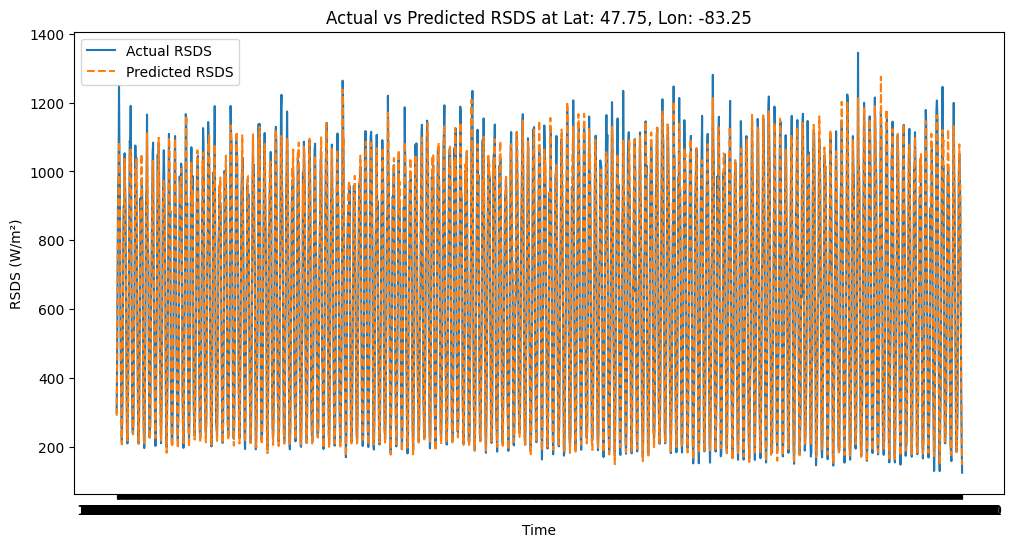

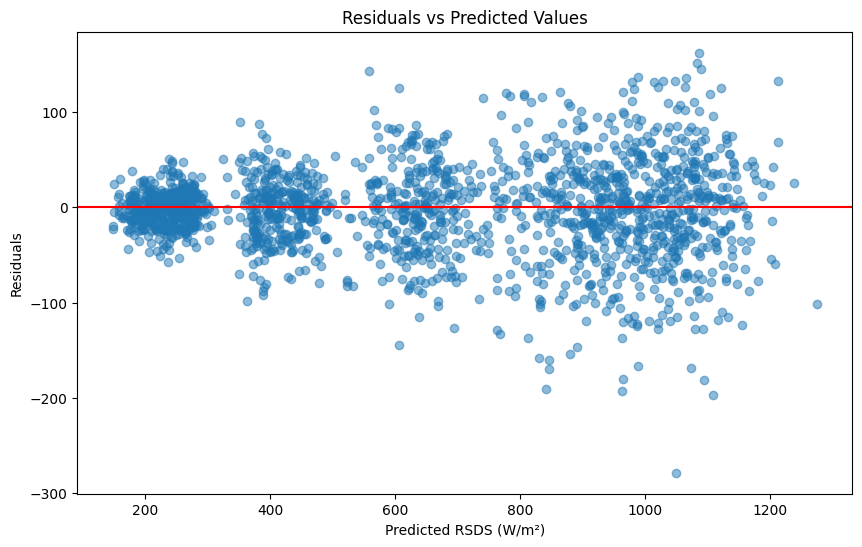

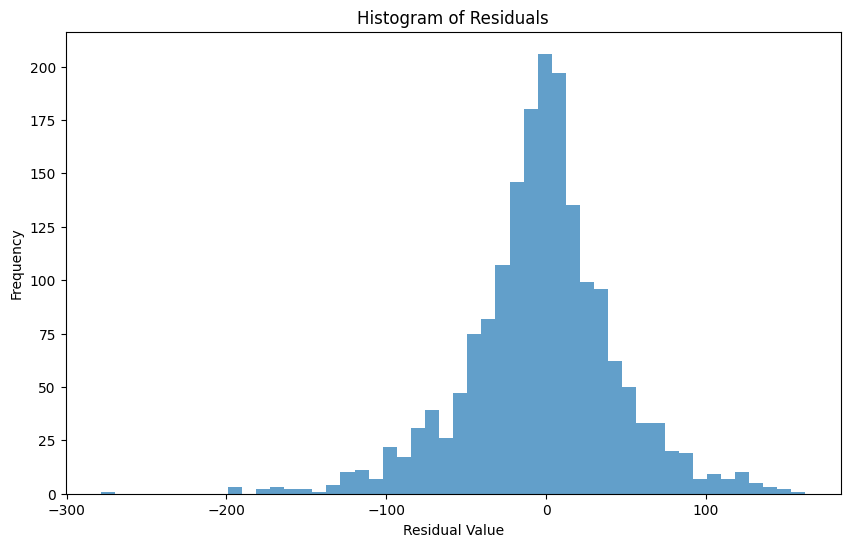

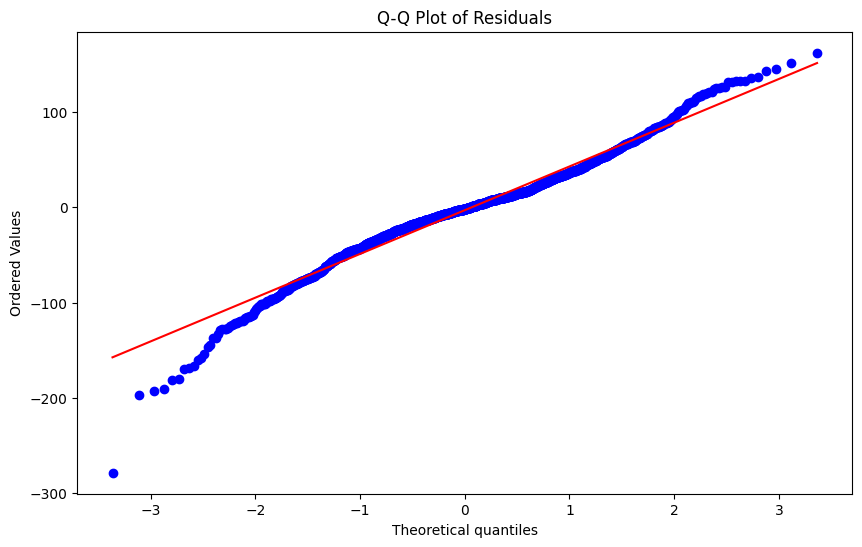

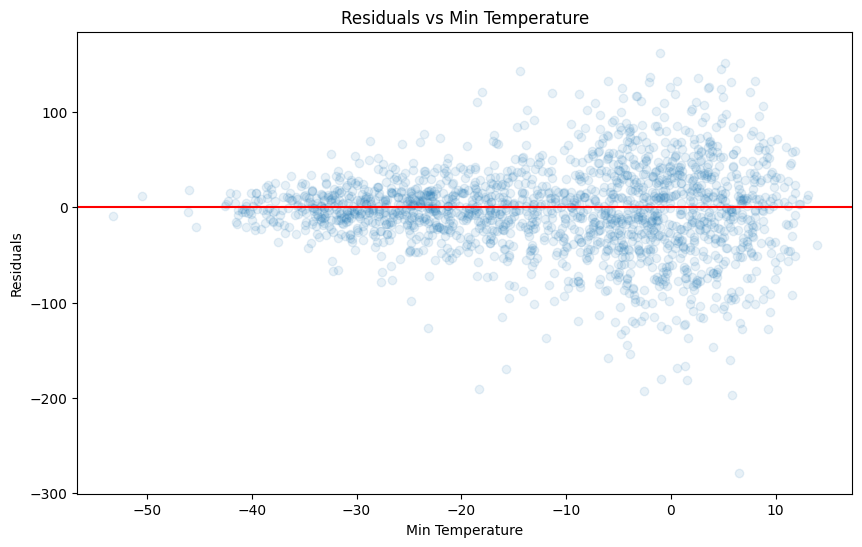

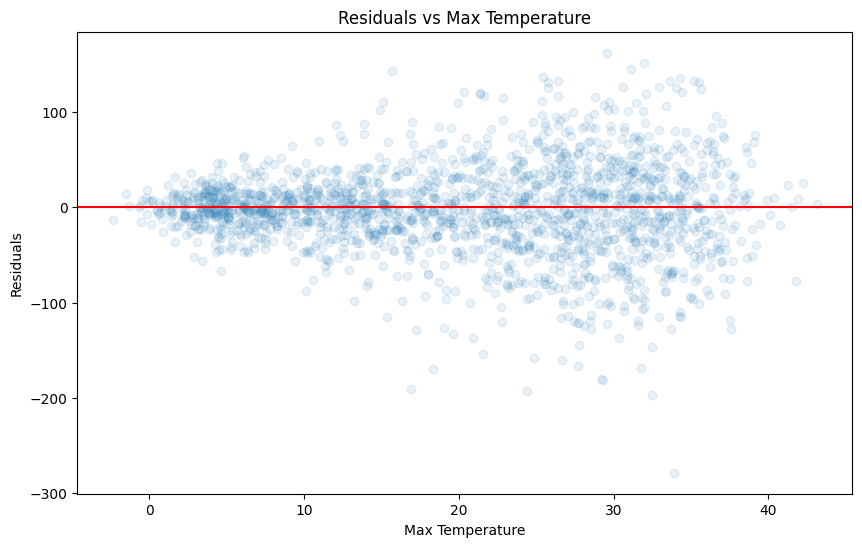

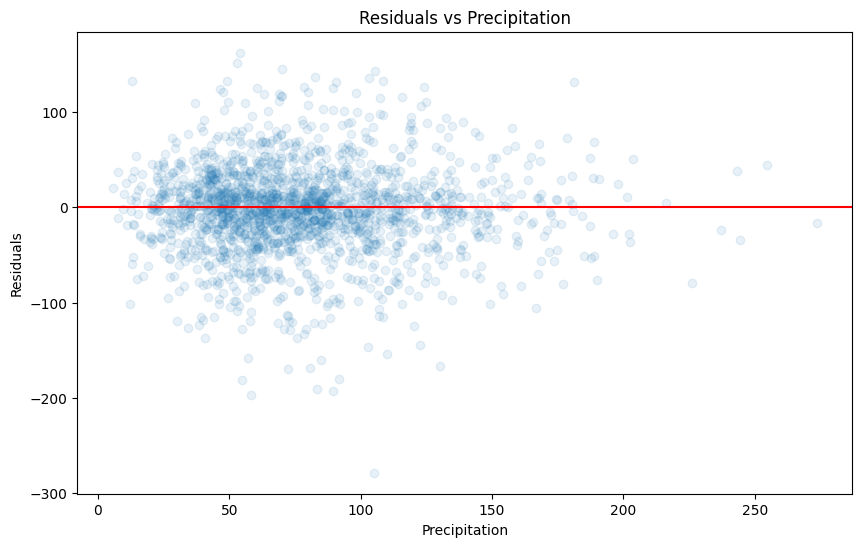

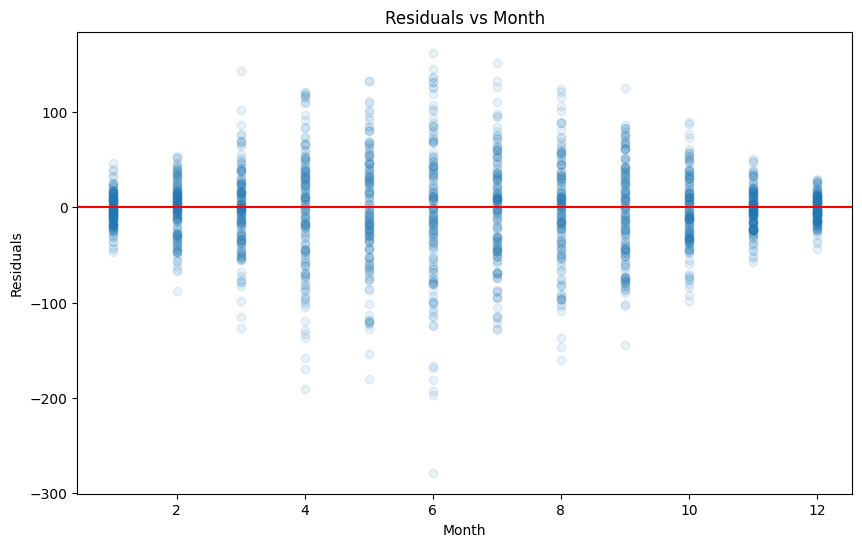

In [28]:
# Second step : Now that we have the data ready to use, we can fit a GAM to predict PAR (rsds) relative to temperature and precipitation and month
# We take the opportunity to create several plots to diagnose the performance of the GAM
from pygam import GAM, s, te, f
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import random
import numpy as np
import os

# Fit GAM model
print("Reading climate data from CanLEADv1")
merged_df = pd.read_csv('ReferencesAndData/dataInputForModel_CanLEADv1.csv')
X = merged_df[['tasminAdjust', 'tasmaxAdjust', 'prAdjust', 'month']]
y = merged_df['rsdsAdjust']

# Define the GAM model
# Here, with interactions : https://r.qcbs.ca/workshop08/book-en/gam-with-interaction-terms.html
# Assuming X is your feature matrix and y is your target variable
# Create weights that emphasize higher values
weights = y / np.mean(y)

# Create a GAM with appropriate terms for periodic data
# This is the best one I got so far in terms of AIC and normal distribution of the residuals.
gam = GAM(
    # Use standard smooth terms with higher n_splines for flexibility
    s(0) +

    # For interaction terms
    te(0, 2) +
    te(1, 2) +
	te(0, 3) +
	te(1, 3) +

    # Add individual smooth terms
    s(1) +
    s(2) +

    # Keep the categorical variable
    f(3),

    distribution='gamma',
    link='log'
)

print("Fitting GAM model...")
# Fit the model with the weights
gam.fit(X, y, weights=weights)

# Print summary
print(gam.summary())

# Make predictions
merged_df['rsds_pred'] = gam.predict(X)

# Calculate R-squared
r_squared = gam.statistics_['pseudo_r2']['explained_deviance']
print(f"R-squared: {r_squared}")

# Plot results for 5 random locations
unique_locations = merged_df[['lat', 'lon']].drop_duplicates().values.tolist()
if len(unique_locations) < 5:
    selected_locations = random.sample(unique_locations, len(unique_locations))
else:
    selected_locations = random.sample(unique_locations, 5)
for i, (lat, lon) in enumerate(selected_locations):
    location_data = merged_df[(merged_df['lat'] == lat) & (merged_df['lon'] == lon)]
    if location_data.empty:
        print(f"No data found for location {lat}, {lon}")
        continue
    plt.figure(figsize=(12, 6))
    plt.plot(location_data['time'], location_data['rsdsAdjust'], label='Actual RSDS')
    plt.plot(location_data['time'], location_data['rsds_pred'], label='Predicted RSDS', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('RSDS (W/m²)')
    plt.title(f'Actual vs Predicted RSDS at Lat: {lat}, Lon: {lon}')
    plt.legend()
    # plt.savefig(f'plots/rsds_prediction_location_{i+1}.png', dpi = 300)
    # plt.close()

# Plot residuals
# Calculate residuals
predictions = gam.predict(X)
residuals = y - predictions
# Create directory for plots if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')
# Plot 1: Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted RSDS (W/m²)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
# plt.savefig('plots/residuals_vs_predicted.png')
# plt.close()
# Plot 2: Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
# plt.savefig('plots/residuals_histogram.png')
# plt.close()
# Plot 3: QQ plot of residuals
plt.figure(figsize=(10, 6))
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
# plt.savefig('plots/residuals_qq_plot.png')
# plt.close()
# Plot 4: Residuals vs each predictor
feature_names = ['Min Temperature', 'Max Temperature', 'Precipitation', 'Month']
for i, feature in enumerate(X.columns):
    plt.figure(figsize=(10, 6))
    plt.scatter(X.iloc[:, i], residuals, alpha=0.1)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel(feature_names[i])
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs {feature_names[i]}')
    # plt.savefig(f'plots/residuals_vs_{feature}.png')
    # plt.close()

Concerning the diagnostic of the GAM : we can see that the predicted values are very close to the observed values. Residuals are overall distributed normally, but are higher for certains months (summer) and for low precipitation/high temperatures (surely a correlation to summer). It makes sense since the values of PAR are much higher and variable in the summer - which results in higher residuals. These tendancies are also observed on larger areas than the one that we are dealing with here.

In [29]:
# Third step : we use the GAM to predict PAR from the temperature and precipitation data that we took from CanDSC-M6 earlier.
# Run the previous cell before running this one

df_climateData = pd.read_csv('ReferencesAndData/dataFrameClimate.csv')
X = df_climateData[['Tmin', 'Tmax', 'SumOfPrecipitations', 'Month']]
df_climateData['PAR_umol/m2/s'] = gam.predict(X) # Careful about the units ! We formatted the input data of the GAM for umol/m2/s, the default unit in PnET
df_climateData.to_csv("ReferencesAndData/dataFrameClimate.csv", sep=',', index=False, encoding='utf-8')

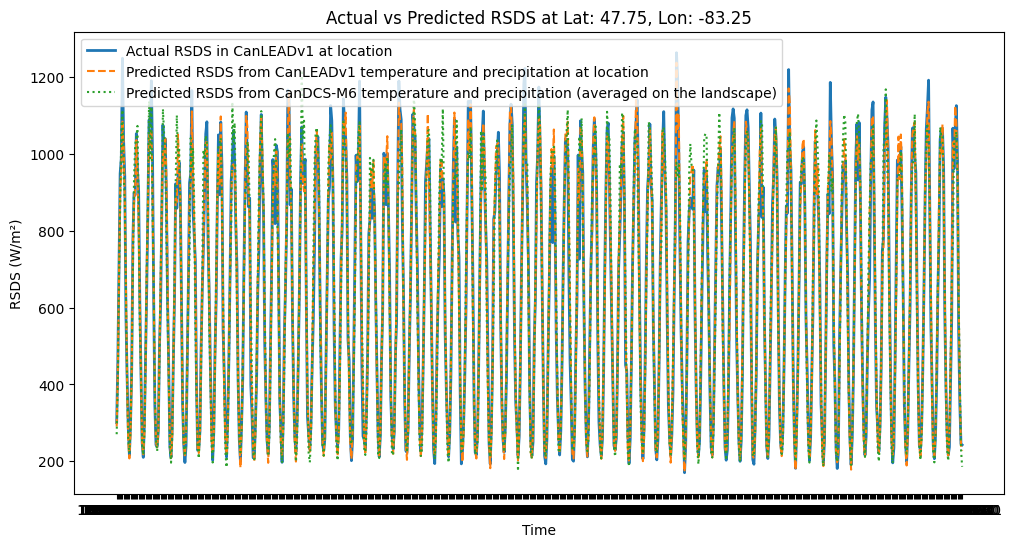

In [31]:
# Outputing a diagnostic plot for the first location in the data of CanLEADv1 versus the average data we've done for CanDSC-M6 data
location = merged_df.iloc[0][['lat', 'lon']]
location_data_CanLEADv1 = merged_df[(merged_df['lat'] == location['lat']) & 
                          (merged_df['lon'] == location['lon'])]
# We add a time column to CanDCS-M6 data
df_climateData["time"] = df_climateData["Year"].astype(str) + "-" + df_climateData["Month"].astype(str) + "-01"

lengthOfData = len(df_climateData['PAR_umol/m2/s'])

plt.figure(figsize=(12, 6))
plt.plot(location_data_CanLEADv1['time'][0:lengthOfData], location_data_CanLEADv1['rsdsAdjust'][0:lengthOfData], label='Actual RSDS in CanLEADv1 at location', linewidth=2)
plt.plot(location_data_CanLEADv1['time'][0:lengthOfData], location_data_CanLEADv1['rsds_pred'][0:lengthOfData], label='Predicted RSDS from CanLEADv1 temperature and precipitation at location', linestyle='--')
# We use the same time data as CanLEADv1, as the measurements are for the exact same months anyway.
plt.plot(location_data_CanLEADv1['time'][0:lengthOfData], df_climateData['PAR_umol/m2/s'], label='Predicted RSDS from CanDCS-M6 temperature and precipitation (averaged on the landscape)', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('RSDS (W/m²)')
plt.title(f'Actual vs Predicted RSDS at Lat: {location["lat"]}, Lon: {location["lon"]}')
plt.legend()
plt.show()

The predicted values show a really good fit on both CanLEADv1 (the training data) and CanDCS-M6 data. The seasonal variance, along with the year to year variance in the high and lows seem to be conserved really well.

I'm certain that other approaches can be even better, but that will do great for calibration purposes.

As such, we end up with a data frame containing Precipitations, Tmin, Tmax and Par for historical (1950-2010) data, with precipitations, Tmin and Tmax coming from the model closest to the concensus in CanDCS-M6 (see above), and PAR coming from a statistical model trained on CanLEADv1 data.

In [36]:
print(pd.read_csv('ReferencesAndData/dataFrameClimate.csv'))

     Year  Month       Tmax       Tmin  SumOfPrecipitations  PAR_umol/m2/s
0    1950      1   1.766656 -40.488547            82.018227     270.510895
1    1950      2   3.891656 -30.540625           121.325523     401.440252
2    1950      3   7.339594 -32.717703            53.020832     670.449927
3    1950      4  22.693750 -14.910406            68.468750     862.178207
4    1950      5  28.860406  -6.858344            51.800781    1054.423142
..    ...    ...        ...        ...                  ...            ...
727  2010      8  30.714594   5.745844            59.013020     922.042915
728  2010      9  26.756250   0.412500            78.882812     620.712206
729  2010     10  25.725000  -6.327094            81.093750     412.238905
730  2010     11  12.475000 -14.025000            73.684898     232.457689
731  2010     12   8.402094 -23.025000            77.760414     185.960717

[732 rows x 6 columns]


### Climate source for ☁️ CO2 concentrations

While there are local variations around the atmosphere in CO2 concentrations (see [here](https://earthobservatory.nasa.gov/images/82142/global-patterns-of-carbon-dioxide)), the differences are small, and it seems like global values can be used (see [here](https://earthobservatory.nasa.gov/blogs/earthmatters/2016/12/05/reader-question-does-co2-disperse-evenly-around-the-earth/)).

Data from https://www.nature.com/articles/s41597-022-01196-7#Sec5 seems very promising : available at https://zenodo.org/records/5021361, not too big, allows for local variations in CO2 concentration. Would need to script the download and treatment of the files here. Timestep is already monthly. Goes to 2150, so perfect for our uses.

Justification for using the dataset :

- We know that this CO2 dataset does not come from the same GCM that generated our climate data, and there could be variability between the variability of climate variables in one dataset versus the climate variables in the models that generated these CO2 estimates at each given timestep.
- However, We thought it better to use this dataset to approximate CO2 spatial and temporal variations in our simulations rather than using latitudinal or global averages. 

In [37]:
# First, we download the CO2 data from https://zenodo.org/records/5021361 

from functionsForCalibration import *
import pandas as pd
import urllib.request
import subprocess
import os

# We use the zenodo_get library to download files from Zenodo very fast; other methods tend to be slow.
# See https://github.com/dvolgyes/zenodo_get . It is installed in the Docker image.
# WARNING : will take around 1.5GB of space for the data from 1950 to 2150 for a full climate scenario.

# We download the file with historical data
os.system("cd ReferencesAndData && zenodo_get 5021361 -g CO2_1deg_month_1850-2013.nc")

# Then, we download the file with future data
# Not needed here since we're working with historical data only, but can be re-used in the future
# os.system("cd ReferencesAndData && zenodo_get 5021361 -g CO2_SSP126_2015_2150.nc")

# We download the .nc files

# WARNING : Download from Zenodo seems to be relatively slow, even with a good connection. Expect at least 20min of download.
# urllib.request.urlretrieve("https://zenodo.org/records/5021361/files/CO2_1deg_month_1850-2013.nc?download=1",
                           # "./ReferencesAndData/CO2_1deg_month_1850-2013.nc",
                          # reporthook=progress_hook)

# urllib.request.urlretrieve("https://zenodo.org/records/5021361/files/CO2_SSP126_2015_2150.nc?download=1",
                           # "./ReferencesAndData/CO2_SSP126_2015_2150.nc",
                          # reporthook=progress_hook)

Title: Global monthly distributions of atmospheric CO2 concentrations under the historical and future scenarios
Keywords: Atmospheric chemistry, Atmospheric dynamics, Climate and Earth system modelling
Publication date: 2021-06-23
DOI: 10.5281/zenodo.5021361
Total size: 1.0 GB

Link: https://zenodo.org/records/5021361/files/CO2_1deg_month_1850-2013.nc   size: 1.0 GB

Checksum is correct. (b11db6cc374ce23fd41b3b078cc8ebdd)
All files have been downloaded.


0

In [1]:
from functionsForCalibration import *

historical_ds = xr.open_dataset("./ReferencesAndData/CO2_1deg_month_1850-2013.nc")
# future_ds = xr.open_dataset("./ReferencesAndData/CO2_SSP126_2015_2150.nc")
# To use the same functions that we used before for temperature and precipitation, we have to standardize the dataset
# Because it uses latitude and longitude as variables rather than coordinates.
# historical_ds = standardize_xarray_dataset(historical_ds)
# future_ds = standardize_xarray_dataset(future_ds)

# We load the dataframe
df_climate = pd.read_csv("./ReferencesAndData/dataFrameClimate.csv")

# Paths to the files
shapefile = "./ReferencesAndData/ChapleauBoundariesClimate.shp"

# historical_ds

In [4]:
# Process the data and fill the dataframe
# Function is in functionsForCalibration.py
df_climate = process_co2_data(historical_ds, shapefile, df_climate)

# Display the updated dataframe
print(df_climate.head())
print(df_climate.tail())

# Plot CO2 concentration over time
# plt.figure(figsize=(12, 6))
# yearly_avg = df_climate.groupby('Year')['CO2_Concentration'].mean()
# plt.plot(yearly_avg.index, yearly_avg.values)
# plt.title('Average CO2 Concentration Over Time')
# plt.xlabel('Year')
# plt.ylabel('CO2 Concentration (ppm)')
# plt.grid(True)
# plt.savefig('co2_concentration_trend.png')
# plt.show()

# We update the data frame file
df_climate.to_csv("./ReferencesAndData/dataFrameClimate.csv", sep=',', index=False, encoding='utf-8')

# We delete the climate files once it's over to free up space
os.remove("./ReferencesAndData/CO2_1deg_month_1850-2013.nc")
# os.remove("./ReferencesAndData/CO2_SSP126_2015_2150.nc")

No points found inside the polygon for historical data. Finding closest point...
Closest point to polygon centroid for historical data: Lon=-83.5, Lat=47.5
   Year  Month       Tmax       Tmin  SumOfPrecipitations  PAR_umol/m2/s  \
0  1950      1   1.766656 -40.488547            82.018227     270.510895   
1  1950      2   3.891656 -30.540625           121.325523     401.440252   
2  1950      3   7.339594 -32.717703            53.020832     670.449927   
3  1950      4  22.693750 -14.910406            68.468750     862.178207   
4  1950      5  28.860406  -6.858344            51.800781    1054.423142   

   CO2_Concentration  
0         317.369324  
1         317.919434  
2         318.526337  
3         316.885101  
4         313.878418  
     Year  Month       Tmax       Tmin  SumOfPrecipitations  PAR_umol/m2/s  \
727  2010      8  30.714594   5.745844            59.013020     922.042915   
728  2010      9  26.756250   0.412500            78.882812     620.712206   
729  2010     1

### Averaging climate data in constant historical averages

As said at the beginning, [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) recommends using a constant climate for calibrating (p. 69). Therefore, we are going to transform our climate data from a monthly year-by-year data into 12 values of historical averages for each months.

In [8]:
import pandas as pd

df_climate = pd.read_csv("./ReferencesAndData/dataFrameClimate.csv")

monthly_avg = df_climate.groupby('Month').agg({
    'Tmax': 'mean',
    'Tmin': 'mean',
    'SumOfPrecipitations': 'mean',
    'PAR_umol/m2/s': 'mean',
    'CO2_Concentration' : 'mean'
}).reset_index()

# Add a Year column with the range of years
min_year = df_climate['Year'].min()
max_year = df_climate['Year'].max()
monthly_avg['Year'] = f"{min_year}-{max_year}"

# Reorder columns to match the desired output
monthly_avg = monthly_avg[['Year', 'Month', 'Tmax', 'Tmin', 'PAR_umol/m2/s', 'SumOfPrecipitations', 'CO2_Concentration']]

# Display the result
print(monthly_avg)

# Export to new file
monthly_avg.to_csv("./ReferencesAndData/dataFrameClimate_historicalAverage.csv", sep=',', index=False, encoding='utf-8')

         Year  Month       Tmax       Tmin  PAR_umol/m2/s  \
0   1950-2010      1   0.737464 -36.896498     271.636886   
1   1950-2010      2   3.655669 -35.664175     447.422742   
2   1950-2010      3  10.778963 -30.476673     666.168402   
3   1950-2010      4  19.205361 -17.522951     886.976261   
4   1950-2010      5  27.262398  -5.332206    1016.673341   
5   1950-2010      6  29.237466  -0.112261    1036.693091   
6   1950-2010      7  29.977732   3.811920    1035.283419   
7   1950-2010      8  28.259153   2.469024     878.605910   
8   1950-2010      9  25.260178  -2.407344     601.087783   
9   1950-2010     10  20.470730  -7.518171     393.313548   
10  1950-2010     11  10.695115 -19.211901     237.569868   
11  1950-2010     12   3.242077 -31.874726     208.661801   

    SumOfPrecipitations  CO2_Concentration  
0             73.912942         347.781625  
1             58.297990         348.370057  
2             64.171854         348.695298  
3             58.614002   